In [2]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import scipy.signal as sig
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')

%matplotlib ipympl

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Finding the frequency response of a FIR filter

* **AIS2201 - Signal Processing**
* **Week 43, 2025**
* **Related reading materials:**
    * Chapters 5.2, 5.9 & 5.10 in Understanding Digital Signal Processing
    * Differentiator filters can be read about in chapter 7.1
* **Lecturerer: Kai Erik Hoff**

# Topics

* Recap of impulse response and convolution
* What is frequency response?
* Magnitude response
* Phase response
* Presentation and interpretation of frequency response
* Calculation of frequency response using the DTFT
* Convolution in the frequency domain


## Recap impulse response

* **All** LTI-systems can be characterized by their *impulse response*

<img src="figures/impulse_response.svg" style="width: 50%; margin-left: 100px" />

## Recap Convolution

* The output signal $y[n]$ of any LTI-system can be computed by *convolving* the input signal $x[n]$ and the system's impulse response $h[n]$

\begin{align*}
y[n] &= x[n]*h[n]\\
&= \sum_{k=0}^{\infty}x[k]\cdot h[n-k]
\end{align*}

Output()

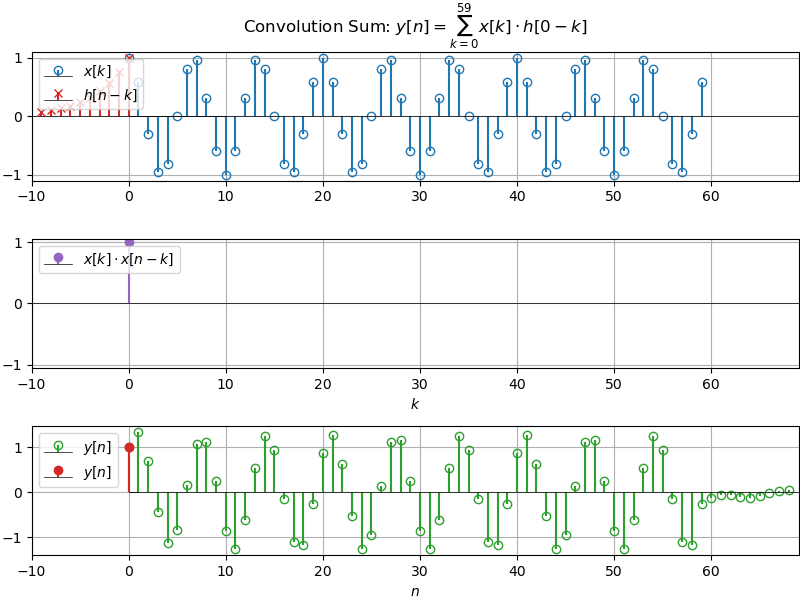

In [4]:
from demos import ConvolutionDemo
n = np.arange(60); xn = np.cos(3*pi/10*n) # x[n] er en Sinussekvens
hn =  0.75**np.arange(10)               # h[n] = 0.75^n, 0 <= n < 10.
ConvolutionDemo(xn, hn, fig_num=1);    

# LTI-systems and sinusoids

* Sinusoid in $\rightarrow$ sinusoid out
    * Both the input and output signal will have the same frequency
* Given the input signal
$$x[n] = \cos\left(\hat{\omega}_0\cdot n\right)$$
the filter will produce a sinusoidal output
$$y[n] = A\cdot \cos\left(\hat{\omega}_0\cdot n +\phi\right)$$




* Our main goal:
> To find a simple and generalized approach to identifying what the new amplitude $A$ and phase $\phi$ will be for any given frequency $\hat{\omega_0}$.

# FIR Filtering of a Sinusoid

* Output is a linear combination of input samples stretching backwards in time:
$$y[n] = \sum_{k=0}^{N} b_k\cdot x[n-k]$$
    * Implies that a input sample $x[n-N]$ which is $N$ samples "old" will still influence the output $y[n]$
    * Output signal $y[n]$ will therefore "lag behind" the input

<img src="figures/Fig1_Sine_ex1.png" style="width: 50%; margin-left: 100px" />


* Input signal from figure:
$$x[n] = \sin \left(\frac{2\pi}{16} \cdot n\right)$$
* Resulting output:
\begin{align*}
y[n] &= 0.925\cdot \sin \left(\frac{2\pi}{16} \cdot (n-2) \right)\\
&= 0.925\cdot \sin \left(\frac{2\pi}{16} \cdot n -\frac{2\pi}{16}\cdot 2 \right)\\
&= 0.925\cdot \sin \left(\frac{\pi}{8} \cdot n -\frac{\pi}{4} \right) 
\end{align*}
    * Slight attenuation and negative phase shift

## "Probing" a FIR filter with sinusoids

* Below is an interactive code example which shows a comparison of sinusoidal input/output for the filter $h[n] = \frac{1}{16} \cdot x[n] + \frac{1}{4} \cdot x[n-1] + \frac{3}{8} \cdot x[n-2] + \frac{1}{4} \cdot x[n-3] + \frac{1}{16} \cdot x[n-4]$
    * Adjusting the frequency can be used as a crude approach to mapping the filter's response for each possible sinusoid.

interactive(children=(IntSlider(value=2, description='f', max=49, min=2), Output()), _dom_classes=('widget-int…

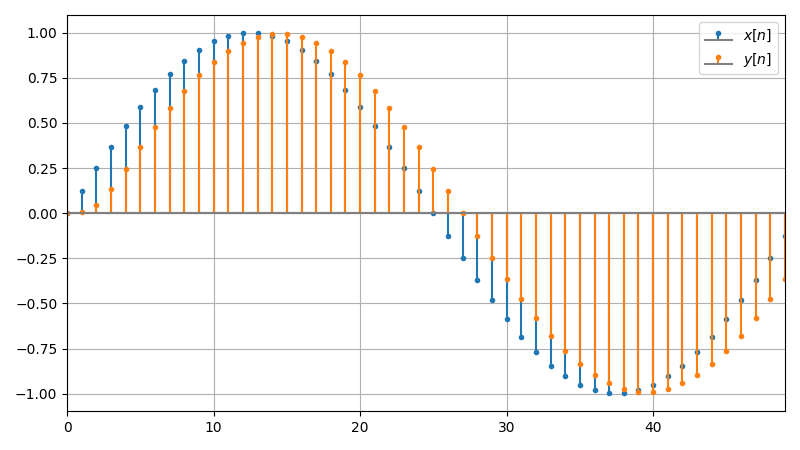

In [12]:
from ipywidgets import interact, IntSlider
fs = 100 # Sampling Frequency
hn = np.array([1, 4, 6, 4, 1])/16 # h[n] = 1/16*h[n] + 1/4*h[n-1] + 3/8*h[n-2] + 1/4*h[n-3] + 1/16*h[n-4]

plt.close(2); plt.figure(2);
@interact(f = IntSlider(min=2, max=fs//2-1, step=1, value=2))
def display_xn_yn(f):
    w = 2*np.pi*f/fs
    n = np.arange(fs//2)
    xn = np.sin(w*n)
    yn = np.convolve(xn, hn)
    plt.cla()
    plt.stem(n, xn, basefmt="grey", linefmt="C0", markerfmt=".C0", label="$x[n]$")
    plt.stem(n, yn[n], basefmt="grey", linefmt="C1", markerfmt=".C1", label="$y[n]$")
    plt.legend()

## Example:
* We have the following filter:
$$h[n] =\frac{1}{4}\delta[n] + \frac{1}{2}\delta[n-1] + \frac{1}{4}\delta[n-2]$$
* An input signal $x[n] = \cos\left(\frac{\pi}{2}\cdot n\right), \ \ n \in \mathbb{Z}$ is used as input
* Find an expression for the output signal $y[n]$.

Output()

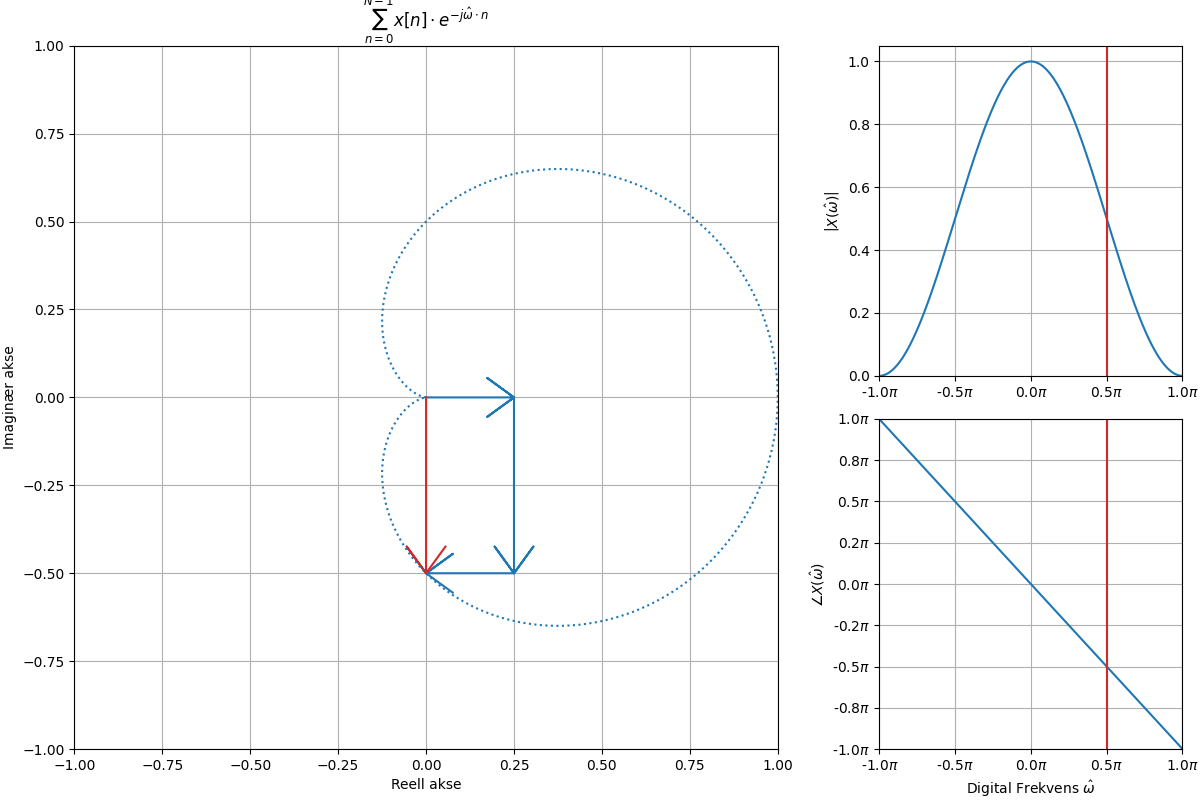

In [10]:
from demos import DTFT_Demo
hn = np.array([1/4, 1/2, 1/4])
DTFT_Demo(hn, fig_num=1).update(omega=0.5);    

# Generalized derivation for sinusoids

\begin{align*}
y[n] &= h[n]*x[n], \ \ \ x[n] = \cos(\hat{\omega}_0\cdot n)\\
&= h[n]*\cos(\hat{\omega}_0\cdot n)\\
&= \sum_{k=0}^{\infty}h[k]\cdot \cos(\hat{\omega}_0\cdot (n-k))\\
&= \sum_{k=0}^{\infty}h[k]\cdot \cos(\hat{\omega}_0\cdot n-\hat{\omega}_0\cdot k)\\
&= A\cos(\hat{\omega}_0\cdot n + \phi)
\end{align*}


$$\text{The phasor addition principle gives:}$$



$$ 
\begin{align*}
A\cdot e^{j\phi} &= \sum_{k=0}^{\infty}h[k]\cdot e^{-j\hat{\omega}_0\cdot k} \\
&= DTFT(h[n])\big|_{\hat{\omega}= \hat{\omega}_0}\\
&= H\left(\hat{\omega}_0 \right)
\end{align*}
$$


#### Key takeaway:
* The magnitude and phase of the output signal is determined by the *fourier transform* of the impulse response $h[n]$ at the frequency $\hat{\omega} = \hat{\omega}_0$
* **Filter analysis = signal analysis**!

## Calculating the Frequency Response using Python

* Filter analysis = signal analysis of $h[n]$

* We can approximate the DTFT of $h[n]$ using zero padding!
    * Example: $h[n] =\frac{1}{4}\delta[n] + \frac{1}{2}\delta[n-1] + \frac{1}{4}\delta[n-2]$

Text(0.5, 0, 'Frequency $f$ (Hz)')

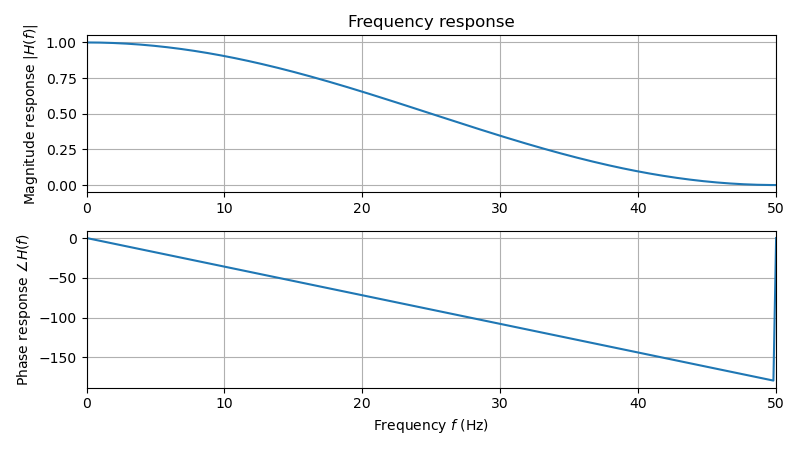

In [10]:
hn = np.array([1/4, 1/2, 1/4])
fs = 100 # Sampling Frequency in samples per second

Hf = np.fft.rfft(hn, n=512)
f = np.fft.rfftfreq(n=512, d=1/fs) #np.arange(0, 257)/512*fs

plt.close(3); plt.figure(3)
plt.subplot(2,1,1)
plt.plot(f, np.abs(Hf))
plt.title("Frequency response")
plt.ylabel("Magnitude response $|H(f)|$")
plt.subplot(2,1,2)
plt.plot(f, np.rad2deg(np.angle(Hf)))
plt.ylabel("Phase response $\\angle H(f)$")
plt.xlabel("Frequency $f$ (Hz)")

## Shortcut: `freqz`:

* We can use the built-in function [`freqz()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html). 
    * `freqz()` is not dissimilar to `fft()`, but has some added options.
* **Arguments:**
    * `b`: Filter coefficients $b_k$
    * `a`: Filter coefficients $a_k$ (*for IIR-filters*)
    * `worN`: Number of data points(*512 dersom annet ikke spesifisert*) 
    * `fs`: sampling frequency
* **Return values:**
    * `w`/`f`: frequency array. Normalized angular frequency $0 \leq \hat{\omega} < \pi$ if `fs` is not specified, otherwise physical frequency $0 \leq f < \frac{f_s}{2}$
    * `H`: Array of response values matching frequency datapoints in `w`/`f`.

In [ ]:
hn = np.array([1/4, 1/2, 1/4])
fs = 100 # Sampling Frequency in samples per second

f, Hf = sig.freqz(b=hn, a=[1], fs=fs)

plt.close(4); plt.figure(4)
plt.subplot(2,1,1)
plt.plot(f, np.abs(Hf))
plt.title("Frequency response")
plt.ylabel("Magnitude response $|H(f)|$")
plt.subplot(2,1,2)
plt.plot(f, np.rad2deg(np.angle(Hf)))
plt.ylabel("Phase response $\\angle H(f)$")
plt.xlabel("Frequency $f$ (Hz)")

# Summary: Calculating Frequency Response

* The frequency response of a digital filter is identified by finding the *frequency content* $H(\hat{\omega})$ of the filter’s impulse response $h[n]$.

  * Can be done analytically with the *Discrete-Time Fourier Transform (DTFT)*
    $$H\left(\hat{\omega} \right) = \text{DTFT}(h[n]) = \sum_{n=0}^{\infty} h[n]\cdot e^{-j\hat{\omega}\cdot n}$$
  * Can be done numerically in `Python` with the function `scipy.signal.freqz()`:

```python
w, Hw = scipy.signal.freqz(hn)
```



# Questions?